# Postprocessing Demo
This notebook explains step by step how raw depth maps are refined and cleaned up.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import csv
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from mit_semseg.utils import colorEncode

from megadepth.postprocessing.image_processing import erode_and_remove, filter_unstable_depths
from megadepth.postprocessing.semantic_filtering import (
    get_mask,
    apply_semantic_filtering,
    get_ordinal_labels,
    is_selfie_image,
)
from megadepth.postprocessing.semantic_segmentation import (
    get_segmentation_map,
    get_segmentation_model,
)
from megadepth.utils.io import load_depth_map

In [3]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(10, 10))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()


# ADE20K dataset information
colors = scipy.io.loadmat("color150.mat")["colors"]
names = {}
with open("object150_info.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

Feel free to change the variables in the following cell to try out other images and depth maps:

In [4]:
dense_model_dir = os.path.join("..", "data", "south-building", "dense", "colmap")
image_fn = "P1180218.JPG"

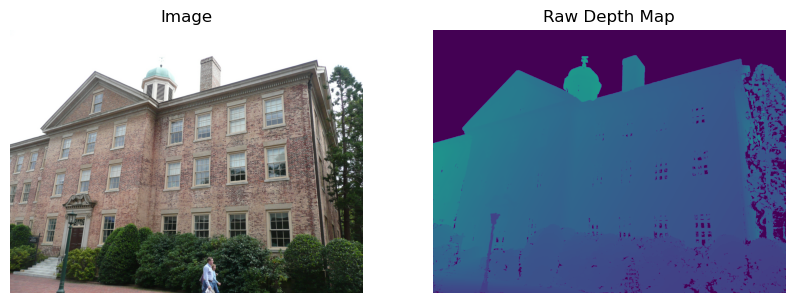

In [5]:
image = Image.open(os.path.join(dense_model_dir, "images", image_fn)).convert("RGB")
depth_map = load_depth_map(os.path.join(dense_model_dir, "stereo", "depth_maps", f"{image_fn}.geometric.bin"))

plot_images([image, depth_map], ["Image", "Raw Depth Map"])

### Semantic Segmentation
As a first step, we extract a segmentation map from the image.

In [ ]:
model = get_segmentation_model()
segmentation_map = get_segmentation_map(image, model)

plot_images([image, colorEncode(segmentation_map, colors)], ["Image", "Segmentation Map"])

Loading weights for net_encoder
Loading weights for net_decoder


The quality of the segmentation seems to suffer when you reduce the image size.

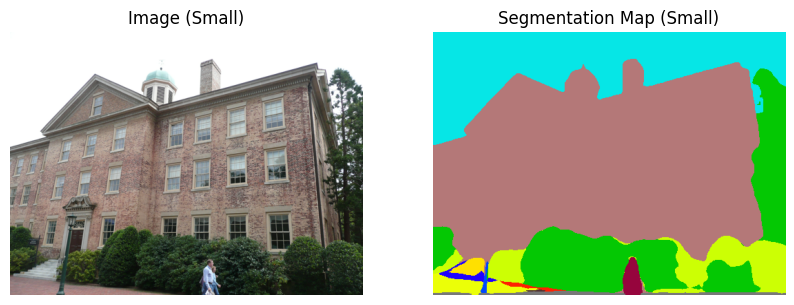

In [ ]:
# downscale image to such that the largest dimension is 512 pixels.
size = 512
scale = size / max(image.size)
new_size = tuple(int(x * scale) for x in image.size)
image_small = image.resize(new_size)

segmentation_map_small = get_segmentation_map(image_small, model)
plot_images([image_small, colorEncode(segmentation_map_small, colors)], ["Image (Small)", "Segmentation Map (Small)"])

### Semantic Filtering

Using the segmentation map, we can extract the following masks:

- **Foreground mask**
    - Labels: person, table, chair, seat, signboard, flower, book, bench, boat, bus, truck, 
    streetlight, booth, poster, van, ship, fountain, bag, minibike, ball, animal, bicycle, 
    sculpture, traffic light, bulletin board
    - Label IDs: 12, 15, 19, 31, 43, 66, 67, 69, 76, 80, 83, 87, 88, 100, 102, 103, 104, 115, 116, 119, 126, 127, 132, 136, 144

- **Background mask**
    - Labels: building, house, skyscraper, hill, tower, waterfall, mountain
    - Label IDs: 1, 25, 48, 68, 84, 113, 16

- **Sky mask**
    - Labels: sky
    - Label IDs: 2

*Note: The label IDs above are 0-indexed (just like in the segmentation maps) while the label IDs in the ADE20K CSV file are 1-indexed.*

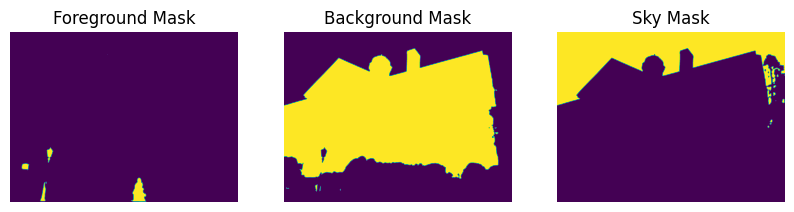

In [ ]:
foreground_mask = get_mask(segmentation_map, "foreground")
background_mask = get_mask(segmentation_map, "background")
sky_mask = get_mask(segmentation_map, "sky")

plot_images([foreground_mask, background_mask, sky_mask], ["Foreground Mask", "Background Mask", "Sky Mask"])

### Image Processing